# YELP Sentiment Classification 

Load Required Library 

In [1]:
import os
import re
import json
import time
import pickle as pk

import pandas as pd
import numpy as np

from sklearn import metrics 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
from nltk.classify import NaiveBayesClassifier, MaxentClassifier

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

from wordcloud import WordCloud

Define working path

In [2]:
path = os.getcwd()
print (path)

/home/machine1/SANDY/nmsm/CA1YU


In [68]:
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

Define working function

In [80]:
#Get unique restaurant_id and restaurant_type for test set
def groupSampling50(group):
    name = group.name
    return group.sample(frac=0.5)

#Create and train the Support Vector Machine.
def train_svm(X, y):
    #svm = SVC(C=10000.0, gamma='auto', kernel='rb')
    svm = LinearSVC(C=5000.0,max_iter=1000)
    svm.fit(X, y)
    return svm

#Create Tokenliser 
def tokenized(reviews): 
    reviews_tokens = [nltk.word_tokenize(t) for t in reviews] 
    reviews_tokens = pd.Series(reviews_tokens)
    return reviews_tokens

#Create word features
def word_feats(words):
    return dict([(word, True) for word in words])

#Plot top ten most importance feature - LinearSVM
def plot_coefficients(classifier, feature_names, top_features=10):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title('Top 10 most informative words. - LinearSVM')
    plt.show()
    
def removeIndent(phrase):
    phrase = re.sub('\n', ' ', phrase)
    phrase = re.sub('\r', ' ', phrase)
    phrase = re.sub('\t', ' ', phrase)
    return phrase

def removePunc(phrase):
    phrase = re.sub('&', ' and ', phrase)
    phrase = re.sub(u'\'', '\'', phrase)
    phrase = re.sub('\%', 'percent', phrase)
    phrase = re.sub('\xa0', '', phrase)
    phrase = re.sub('[^a-z]', ' ', phrase.lower())
    return phrase

# Lemmatiztion
def lemmatize(tokens):
    lemm = []
    #classifier only on the adjectives and noun. This is of course an assumption and premises 
    # nouns and adjectives hold more 'sense sentiment'.
    for word, tag in nltk.pos_tag(tokens, tagset='universal'):
        if tag.startswith('NN'):
            lemm.append(WNlemma.lemmatize(word.lower(), pos='n')) #noun
        elif tag.startswith('VB'): 
            lemm.append(WNlemma.lemmatize(word.lower(), pos='v')) #verb
        elif tag.startswith('JJ'):
            lemm.append(WNlemma.lemmatize(word.lower(), pos='a')) #adjective
        elif tag.startswith('R'):
            lemm.append(WNlemma.lemmatize(word.lower(), pos='r'))
        else:
            lemm.append(word.lower())
    return lemm

def pre_process(reviews):
    WNlemma = nltk.WordNetLemmatizer()
    stop_words = stopwords.words("english")
    
    #negation 
    reformed = [appos[word] if word in appos else word for word in reviews]
    reformed = " ".join(reformed) 
    
    # Remove Indent and Punc
    reviews1= [removePunc(removeIndent(t)).strip() for t in reformed]
    # Tokenlization
    reviews_tokens = [nltk.word_tokenize(t) for t in reviews1]
    # Lemmatiztion
    reviews_lemm = [lemmatize(t) for t in reviews_tokens]
    
    # Removing Stop Words
    reviews_stop = [[t for t in tokens if (t not in stop_words) and len(t.strip()) > 3] for tokens in reviews_lemm]
    
    reviews_stop = pd.Series(reviews_stop)  
    return reviews_stop

Define required column 

In [70]:
restaurant_id    =[]
date             =[]
review_id        =[]
stars            =[]
text             =[]
Sentiment        =[]

restaurant_type  =[]

# [1] Data collection

In [71]:
#Merged all scrapped restaurant reveiw to a dataframe

count = 20577
file_list = os.listdir(path + '/json_rest/')
for f in file_list:
    if f == '.DS_Store':
        continue
    file_path = path + '/json_rest/' + f
    json_file = open(file_path, mode="r")
    rest_data = json.load(json_file)
    
    rest_id = f.split('.')[0] # Read json file name to obtain restaurant ID
    
    for rev in rest_data['reviews']:
        restaurant_id.append(rest_id)
        if rest_data['restaurant_type'] == "":
            restaurant_type.append('NoCategory')
        else:
            restaurant_type.append(rest_data['restaurant_type'])
        date.append(rev['date'])
        count += 1
        review_id.append('revtrain' + str(count)) # Anonymised review name. 
        stars.append(int(float(rev['stars'])))
        text.append(rev['text'])
        
        #Business rules: Use the ratings 1-3 as negative and 4-5 as positive in the Yelp reviews.
        if float(rev['stars']) > 3.5:
            Sentiment.append('positive')
        else:
            Sentiment.append('negative')

    json_file.close()
    
yelp_scraped = pd.DataFrame({
                                'restaurant_id':restaurant_id,
                                'date':date,
                                'review_id':review_id,
                                'stars':stars,
                                'text':text,
                                'Sentiment':Sentiment,
                                'restaurant_type':restaurant_type
                           })

#Show top 5 rows of yelp_scraped dataframe 
yelp_scraped.head()

,restaurant_id,date,review_id,stars,text,Sentiment,restaurant_type
0,tr1052,9/20/2017,revtrain20578,5,Amazing Indian Seafood restaurant Great value!...,positive,Indian
1,tr1052,9/17/2017,revtrain20579,5,Delicious. Great customer service. We asked f...,positive,Indian
2,tr1052,10/15/2015,revtrain20580,4,Not your typical Indian seafood restaurant..Un...,positive,Indian
3,tr1052,10/16/2015,revtrain20581,4,First time in a long time experiencing dining ...,positive,Indian
4,tr1052,12/16/2014,revtrain20582,4,We accidentally came in here because another p...,positive,Indian


In [72]:
print('Basic Figures of the scraped YELP dataset.')
print('------------------------------------------------')
print('Total number of restaurants               : ' + str(len(yelp_scraped['restaurant_id'].unique())))
print('Total number of restaurant reviews        : ' + str(len(yelp_scraped['text'])))
print('Restaurant category                       : ' + str(yelp_scraped['restaurant_type'].unique()))

Basic Figures of the scraped YELP dataset.
------------------------------------------------
Total number of restaurants               : 200
Total number of restaurant reviews        : 5056
Restaurant category                       : ['Indian' 'NoCategory' 'Chinese' 'Italian' 'Japanese' 'Thai' 'Korean']


In [73]:
#Total number of review by restaurant Category 
yelp_scraped.groupby('restaurant_type')['text'].count().sort_values(ascending=False)

restaurant_type
NoCategory    3881
Chinese        460
Indian         259
Japanese       199
Korean         116
Italian         94
Thai            47
Name: text, dtype: int64

In [74]:
#Total number of restaurant by restaurant category 
yelp_scraped.groupby('restaurant_type')['restaurant_id'].nunique().sort_values(ascending=False)

restaurant_type
NoCategory    145
Chinese        16
Japanese       10
Indian         10
Italian         8
Korean          7
Thai            4
Name: restaurant_id, dtype: int64

In [9]:
#Overall Sentiment of the Scrapped dataset
yelp_scraped.groupby('Sentiment')['Sentiment'].count()

Sentiment
negative    1041
positive    4015
Name: Sentiment, dtype: int64

In [10]:
#Create Test Set  
cat_list = ['Chinese', 'Japanese', 'Indian', 'Italian', 'Korean', 'Thai']
test_set = yelp_scraped[yelp_scraped['restaurant_type'].isin(cat_list)]

test_set = test_set.groupby('restaurant_type', group_keys=False).apply(groupSampling50)

print('Total number records in Test Set       : ' + str(len(test_set)))

Total number records in Test Set       : 589


In [11]:
#Create Train Set 
train_set = pd.concat([yelp_scraped,test_set]).drop_duplicates(keep=False)
train_set = train_set.drop(['restaurant_type'], axis=1)
print('Total number records in intial Train Set: ' + str(len(train_set)))

Total number records in intial Train Set: 4467


In [12]:
#Load Standard train dataset
file_path = path + '/data/train.csv'
train_std = pd.read_csv(file_path, encoding="ISO-8859-1")
print('Total number records in Standard Train Set: ' + str(len(train_std)))

Total number records in Standard Train Set: 20329


In [13]:
#Combine Standard train set with scraped dataset
train_set = train_set.append(train_std)
print('Total number records in combined Train Set: ' + str(len(train_set)))

Total number records in combined Train Set: 24796


In [14]:
train_set.head()

,restaurant_id,date,review_id,stars,text,Sentiment
1,tr1052,9/17/2017,revtrain20579,5,Delicious. Great customer service. We asked f...,positive
2,tr1052,10/15/2015,revtrain20580,4,Not your typical Indian seafood restaurant..Un...,positive
5,tr1052,3/24/2015,revtrain20583,4,In town for business and refuse to eat dinners...,positive
8,tr1057,10/21/2018,revtrain20586,4,Came here in my first night at Singapore and I...,positive
9,tr1057,10/16/2018,revtrain20587,4,While Newton tends to be a bit more touristy t...,positive


In [15]:
print('Basic Figures of the final training dataset.')
print('------------------------------------------------')
print('Total number of restaurants               : ' + str(len(train_set['restaurant_id'].unique())))
print('Total number of restaurant reviews        : ' + str(len(train_set['text'])))

Basic Figures of the final training dataset.
------------------------------------------------
Total number of restaurants               : 1069
Total number of restaurant reviews        : 24796


In [16]:
print('Overall (%) Sentiment of the final training dataset.')
print('----------------------------------------------------')
train_set['Sentiment'].value_counts(normalize=True)

Overall (%) Sentiment of the final training dataset.
----------------------------------------------------


positive    0.518672
negative    0.481328
Name: Sentiment, dtype: float64

In [17]:
print('Basic Figures of the final tesing dataset.')
print('------------------------------------------------')
print('Total number of restaurants               : ' + str(len(test_set['restaurant_id'].unique())))
print('Total number of restaurant reviews        : ' + str(len(test_set['text'])))

Basic Figures of the final tesing dataset.
------------------------------------------------
Total number of restaurants               : 55
Total number of restaurant reviews        : 589


In [18]:
print('Overall (%) Sentiment of the final testing dataset.')
print('----------------------------------------------------')
test_set['Sentiment'].value_counts(normalize=True)

Overall (%) Sentiment of the final testing dataset.
----------------------------------------------------


positive    0.801358
negative    0.198642
Name: Sentiment, dtype: float64

In [19]:
#Our target variable we are predicting is sentiment.Convert to numeric values for training and test dataset.
#Postive = [1], Negative = [-1]
train_set['Sentiment'] = train_set.Sentiment.map(lambda x: int(1) if x =='positive' else int(-1))
test_set['Sentiment']  = test_set.Sentiment.map(lambda x: int(1) if x =='positive' else int(-1))

In [20]:
train_set = train_set.reset_index()
test_set  = test_set.reset_index()
train_set.shape, test_set.shape

((24796, 7), (589, 8))

# [2] Baseline Navie Based & SVM

Vectorising training and tesing dataset

In [21]:
x_train = train_set['text']
y_train = train_set['Sentiment']

x_test = test_set['text']
y_test = test_set['Sentiment']

In [22]:
# Create tf-idf vector
vectorizer  = TfidfVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec  = vectorizer.transform(x_test)
print('Show Shape of X train and test vectors.')
print('----------------------------------------------------')
x_train_vec.shape, x_test_vec.shape

Show Shape of X train and test vectors.
----------------------------------------------------


((24796, 38870), (589, 38870))

# [2.1] Training Naive Bayes Model 

In [23]:
nb_clf = MultinomialNB().fit(x_train_vec, y_train)

nb_train_pred_1 = nb_clf.predict(x_train_vec)

nb_train_1_cm = pd.crosstab(pd.Series(y_train), pd.Series(nb_train_pred_1), 
                            rownames=['actuals'], colnames=['predict'],margins=True)

print('-----------------------------------------------------')
print('| Summary Result of Training Naive Bayes Model      |')
print('-----------------------------------------------------')
print(nb_train_1_cm)
print('-----------------------------------------------------')
print(metrics.classification_report(y_train, nb_train_pred_1))
print('-----------------------------------------------------')
print('Total Accuracy :' + str(round(np.mean(nb_train_pred_1 == y_train), 5)))
print('-----------------------------------------------------')

-----------------------------------------------------
| Summary Result of Training Naive Bayes Model      |
-----------------------------------------------------
predict     -1      1    All
actuals                     
-1       10379   1556  11935
1         1039  11822  12861
All      11418  13378  24796
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.91      0.87      0.89     11935
           1       0.88      0.92      0.90     12861

   micro avg       0.90      0.90      0.90     24796
   macro avg       0.90      0.89      0.89     24796
weighted avg       0.90      0.90      0.90     24796

-----------------------------------------------------
Total Accuracy :0.89535
-----------------------------------------------------


# [2.2] Test Naive Bayes Model 

In [24]:
nb_test_pred_1 = nb_clf.predict(x_test_vec)
nb_test_1_cm = pd.crosstab(pd.Series(y_test), pd.Series(nb_test_pred_1), rownames=['actuals'],
                      colnames=['predict'], margins=True)


print('-----------------------------------------------------')
print('| Summary Result of Test Naive Bayes Model          |')
print('-----------------------------------------------------')
print(nb_test_1_cm)
print('-----------------------------------------------------')
print(metrics.classification_report(y_test, nb_test_pred_1))
print('-----------------------------------------------------')
print('Total Accuracy :' + str(round(np.mean(nb_test_pred_1 == y_test), 5)))
print('-----------------------------------------------------')

-----------------------------------------------------
| Summary Result of Test Naive Bayes Model          |
-----------------------------------------------------
predict  -1    1  All
actuals              
-1       43   74  117
1        13  459  472
All      56  533  589
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.77      0.37      0.50       117
           1       0.86      0.97      0.91       472

   micro avg       0.85      0.85      0.85       589
   macro avg       0.81      0.67      0.71       589
weighted avg       0.84      0.85      0.83       589

-----------------------------------------------------
Total Accuracy :0.85229
-----------------------------------------------------


# [2.3] Training SVM Model

In [25]:
#Train SVM model
svm_clf = train_svm(x_train_vec, y_train)  

#Uncomment to export model out as pickles 
pk.dump(svm_clf, open("classifier_svm.pk","wb"))
#Uncomment to read from model.
#svm_clf = pk.load(open("classifier_svm.pk", "rb"))

svm_train_pred_1 = svm_clf.predict(x_train_vec)
svm_train_1_cm   = pd.crosstab(pd.Series(y_train), pd.Series(svm_train_pred_1), rownames=['actual'], colnames=['predict'], margins=True)

print('-----------------------------------------------------')
print('| Summary Result of Train SVM Model                 |')
print('-----------------------------------------------------')
print(svm_train_1_cm)
print('-----------------------------------------------------')
print(metrics.classification_report(y_train, svm_train_pred_1))
print('-----------------------------------------------------')
print('Total Accuracy :' + str(round(np.mean(svm_train_pred_1 == y_train), 5)))
print('-----------------------------------------------------')

-----------------------------------------------------
| Summary Result of Train SVM Model                 |
-----------------------------------------------------
predict     -1      1    All
actual                      
-1       11933      2  11935
1            4  12857  12861
All      11937  12859  24796
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     11935
           1       1.00      1.00      1.00     12861

   micro avg       1.00      1.00      1.00     24796
   macro avg       1.00      1.00      1.00     24796
weighted avg       1.00      1.00      1.00     24796

-----------------------------------------------------
Total Accuracy :0.99976
-----------------------------------------------------


# [2.4] Test SVM Model

In [26]:
svm_test_pred_1 = svm_clf.predict(x_test_vec)
svm_test_1_cm   = pd.crosstab(pd.Series(y_test), pd.Series(svm_test_pred_1), rownames=['actual'], colnames=['predict'], margins=True)

print('-----------------------------------------------------')
print('| Summary Result of Test SVM Model                  |')
print('-----------------------------------------------------')
print(svm_test_1_cm)
print('-----------------------------------------------------')
print(metrics.classification_report(y_test, svm_test_pred_1))
print('-----------------------------------------------------')
print('Total Accuracy :' + str(round(np.mean(svm_test_pred_1 == y_test), 5)))
print('-----------------------------------------------------')

-----------------------------------------------------
| Summary Result of Test SVM Model                  |
-----------------------------------------------------
predict   -1    1  All
actual                
-1       101   16  117
1         50  422  472
All      151  438  589
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.67      0.86      0.75       117
           1       0.96      0.89      0.93       472

   micro avg       0.89      0.89      0.89       589
   macro avg       0.82      0.88      0.84       589
weighted avg       0.90      0.89      0.89       589

-----------------------------------------------------
Total Accuracy :0.88795
-----------------------------------------------------


# [2.5] Training Maximum Entropy Classifier (MaxEnt)

The Maximum entropy classifier is a discriminative classifier in that it looks at the entire dataset and uses a model (normally via optimisation) with parameters to map (_classify_) labels. MaxEnt model is useful when little information is known about the prior distribution.

Word features creation for the training and test dataset

In [27]:
#Tokenization train set
train_set['text_tokens'] = tokenized(train_set['text'])
#Tokenization test set
test_set['text_tokens'] = tokenized(test_set['text'])

x_train_feats = [(word_feats(c['text_tokens']), c['Sentiment']) for (d,c) in train_set.iterrows()]
x_test_feats  = [(word_feats(c['text_tokens']), c['Sentiment']) for (d,c) in test_set.iterrows()]

In [28]:
#Train MaxEnt Model using IIS (improved iterative scaling) optimisation algorithm
#Uncomment to use pretrained model. 
maxent_clf = pk.load(open('classifier_maxent.pk', 'rb'))

#maxent_clf = MaxentClassifier.train(x_train_feats, algorithm='IIS', max_iter=5)

In [29]:
#pk.dump(maxent_clf, open('classifier_maxent.pk', 'wb'))

In [30]:
me_train_pred_1 = []
x_train_tok = [t[0] for t in x_train_feats]
for t in x_train_tok:
    me_train_pred_1.append(maxent_clf.classify(t))

maxent_train_cm = pd.crosstab(pd.Series(y_train), pd.Series(me_train_pred_1), rownames=['actuals'],
                      colnames=['predict'], margins=True)

In [31]:
print('-----------------------------------------------------')
print('| Summary Result of Train MaxEnt Model              |')
print('-----------------------------------------------------')
print(maxent_train_cm)
print('-----------------------------------------------------')
print(metrics.classification_report(y_train, me_train_pred_1))
print('-----------------------------------------------------')
print('Total Accuracy :' + str(round(np.mean(me_train_pred_1 == y_train), 5)))
print('-----------------------------------------------------')

-----------------------------------------------------
| Summary Result of Train MaxEnt Model              |
-----------------------------------------------------
predict   -1      1    All
actuals                   
-1       115  11820  11935
1          7  12854  12861
All      122  24674  24796
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.94      0.01      0.02     11935
           1       0.52      1.00      0.68     12861

   micro avg       0.52      0.52      0.52     24796
   macro avg       0.73      0.50      0.35     24796
weighted avg       0.72      0.52      0.36     24796

-----------------------------------------------------
Total Accuracy :0.52303
-----------------------------------------------------


# [2.6] Test Maximum Entropy Classifier (MaxEnt)

In [32]:
me_test_pred_1 = []
x_test_tok = [t[0] for t in x_test_feats]
for t in x_test_tok:
    me_test_pred_1.append(maxent_clf.classify(t))

maxent_test_cm = pd.crosstab(pd.Series(y_test), pd.Series(me_test_pred_1), rownames=['actuals'],
                      colnames=['predict'], margins=True)

In [33]:
print('-----------------------------------------------------')
print('| Summary Result of Test MaxEnt Model               |')
print('-----------------------------------------------------')
print(maxent_test_cm)
print('-----------------------------------------------------')
print(metrics.classification_report(y_test, me_test_pred_1))
print('-----------------------------------------------------')
print('Total Accuracy :' + str(round(np.mean(me_test_pred_1 == y_test), 5)))
print('-----------------------------------------------------')

-----------------------------------------------------
| Summary Result of Test MaxEnt Model               |
-----------------------------------------------------
predict    1  All
actuals          
-1       117  117
1        472  472
All      589  589
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       117
           1       0.80      1.00      0.89       472

   micro avg       0.80      0.80      0.80       589
   macro avg       0.40      0.50      0.44       589
weighted avg       0.64      0.80      0.71       589

-----------------------------------------------------
Total Accuracy :0.80136
-----------------------------------------------------


# [2.7] Models Comparison 

We created 3 classifier to test our dataset: - 1) Navie Bayes Models 2) MaxEnt 3) SVM (Linear). Of which Navie Bayes and SVM provide the best result in terms of accurracy, precision and recall. Thus we will be using this two models for further experimentings. 

# [3] Top 10 most informative words. - LinearSVM

In [34]:
cv = CountVectorizer()
cv.fit(x_train)
X_train = cv.transform(x_train)

In [35]:
svm = LinearSVC(C=5000.0,max_iter=1000)
svm.fit(X_train, y_train )

LinearSVC(C=5000.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

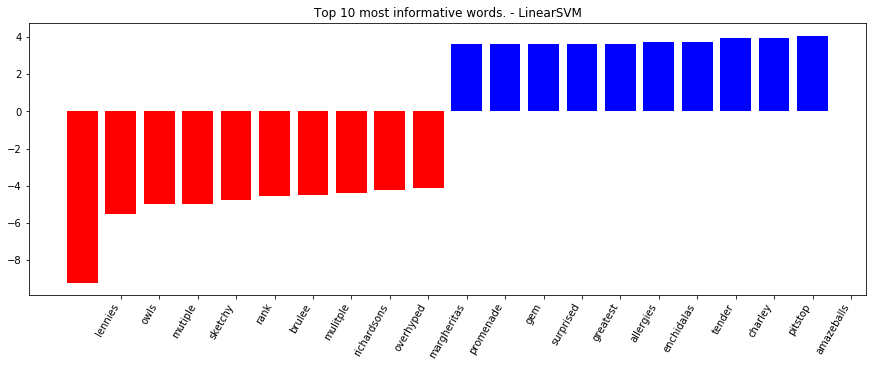

In [36]:
plot_coefficients(svm, cv.get_feature_names())

# [4] Top 10 most informative words. - Navie Bayes

In [37]:
classifier_nb = NaiveBayesClassifier.train(x_train_feats)
print('---------------------------------------------------------------------------------------------')
print('|                     Top 10 most informative words. - Navie Bayes                          |')
print('---------------------------------------------------------------------------------------------')
classifier_nb.show_most_informative_features(10)
print('---------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------
|                     Top 10 most informative words. - Navie Bayes                          |
---------------------------------------------------------------------------------------------
Most Informative Features
                Terrible = True               -1 : 1      =     65.7 : 1.0
                      Wo = True               -1 : 1      =     62.1 : 1.0
              flavorless = True               -1 : 1      =     48.5 : 1.0
                Horrible = True               -1 : 1      =     47.6 : 1.0
            unacceptable = True               -1 : 1      =     39.2 : 1.0
               redeeming = True               -1 : 1      =     37.7 : 1.0
                  rudely = True               -1 : 1      =     37.0 : 1.0
                HORRIBLE = True               -1 : 1      =     37.0 : 1.0
                   WORST = True               -1 : 1      =     31.2 : 1.0
                 

# [5] Text Pre-Process of The Data 

The pre-processing step include:- 
    1) Remove indentation and Punuaction
    2) Tokenisaton
    3) Part of Speech tagging 
    4) Lemmatization
    5) Remove of stop words.

In [ ]:
train_set['text_preproc'] = pre_process(train_set['text'])
train_set['text_preproc_str'] = [" ".join(l) for l in train_set['text_preproc']]
train_set.head()

In [ ]:
test_set['text_preproc']  = pre_process(test_set['text'])
test_set['text_preproc_str'] = [" ".join(l) for l in test_set['text_preproc']]
test_set.head()

# [6] Visualise the dataset after Pre-Processing with Wordcloud by Sentiment

In [41]:
# Segment training dataset by sentiment [postive or negative] 
neg_train_set = train_set.loc[train_set['Sentiment'] == -1]
pos_train_set = train_set.loc[train_set['Sentiment'] ==  1]

In [42]:
neg_train_flat = [c for l in neg_train_set['text_preproc'] for c in l]
pos_train_flat = [c for l in pos_train_set['text_preproc'] for c in l]

neg_train_review  = nltk.FreqDist(neg_train_flat)
pos_train_review  = nltk.FreqDist(pos_train_flat)

# [6.1] Postive Sentiment Wordcloud

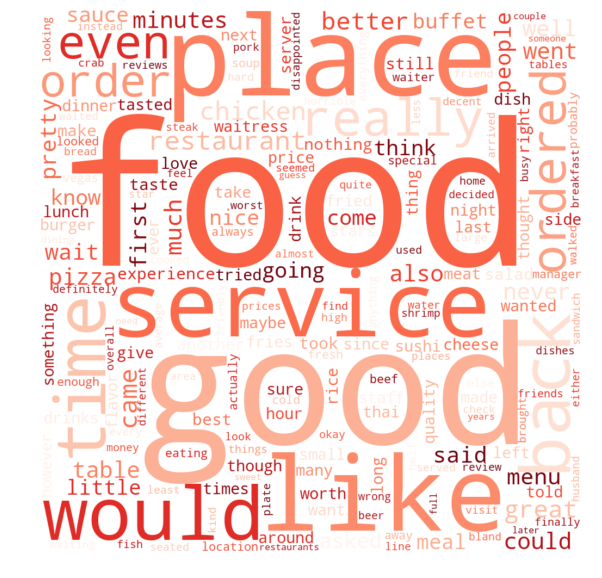

In [59]:
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate_from_frequencies(neg_train_review)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# [6.2] Negative Sentiment Wordcloud

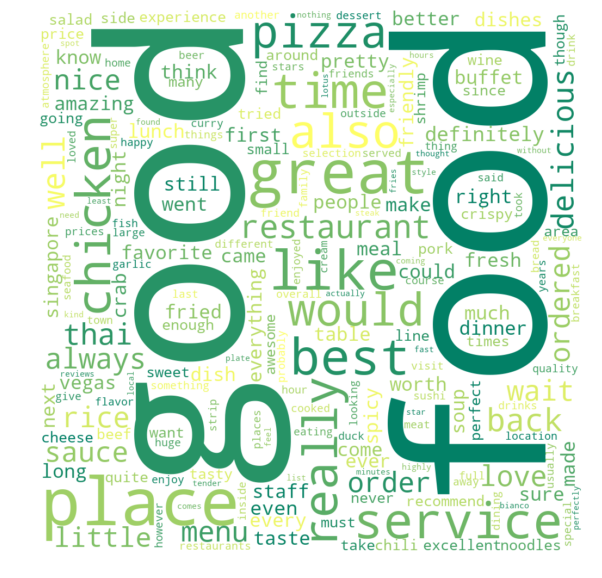

In [60]:
wordcloud_p2 = WordCloud(width=1000, height=1000, colormap='summer',background_color='white', mode='RGBA').generate_from_frequencies(pos_train_review)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_p2, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# [6.3] Wordcloud Obeservations

In the negative cloud, some neutral words are big like 'good', 'food' and 'like'.Some other bigger sized words are 'service', 'time' and 'order' which sugguest that those might be the factors for negative review.

The positive class has larger words 'food' and 'good' which also appears in negative and positive clouds as one of the biggest sizes. Some other mild size word like 'service', 'place' and time sugguest that those might be the factors for positive review.

This suggests most people are highlighting their reviews based on the the food. The word ‘place’ is more prominent in negative cloud than positive cloud sugguest that location is not of a big factors when giving a good review.

# [7] Re-Modelling with Text Pre-Processed Data

Vectorising training and tesing dataset

In [61]:
x_train_pp = train_set['text_preproc_str']
y_train_pp = train_set['Sentiment']

x_test_pp = test_set['text_preproc_str']
y_test_pp = test_set['Sentiment']

In [62]:
# Create tf-idf vector
vectorizer  = TfidfVectorizer()
x_train_vec_pp = vectorizer.fit_transform(x_train_pp)
x_test_vec_pp  = vectorizer.transform(x_test_pp)
print('Show Shape of X train and test vectors for Pre-process data.')
print('----------------------------------------------------')
x_train_vec_pp.shape, x_test_vec_pp.shape

Show Shape of X train and test vectors for Pre-process data.
----------------------------------------------------


((24796, 35461), (589, 35461))

# [7.1] Training Naive Bayes Model

In [63]:
ppnb_clf = MultinomialNB().fit(x_train_vec_pp, y_train_pp)

ppnb_train_pred_1 = ppnb_clf.predict(x_train_vec_pp)

ppnb_train_1_cm = pd.crosstab(pd.Series(y_train_pp), pd.Series(ppnb_train_pred_1), 
                            rownames=['actuals'], colnames=['predict'],margins=True)

print('-----------------------------------------------------')
print('| Summary Result of Training Naive Bayes Model      |')
print('-----------------------------------------------------')
print(ppnb_train_1_cm)
print('-----------------------------------------------------')
print(metrics.classification_report(y_train_pp, ppnb_train_pred_1))
print('-----------------------------------------------------')
print('Total Accuracy :' + str(round(np.mean(ppnb_train_pred_1 == y_train_pp), 5)))
print('-----------------------------------------------------')

-----------------------------------------------------
| Summary Result of Training Naive Bayes Model      |
-----------------------------------------------------
predict     -1      1    All
actuals                     
-1       10232   1707  11939
1          907  11950  12857
All      11139  13657  24796
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.92      0.86      0.89     11939
           1       0.88      0.93      0.90     12857

   micro avg       0.89      0.89      0.89     24796
   macro avg       0.90      0.89      0.89     24796
weighted avg       0.90      0.89      0.89     24796

-----------------------------------------------------
Total Accuracy :0.89458
-----------------------------------------------------


# [7.2] Test Naive Bayes Model

In [64]:
ppnb_test_pred_1 = ppnb_clf.predict(x_test_vec_pp)
ppnb_test_1_cm = pd.crosstab(pd.Series(y_test_pp), pd.Series(ppnb_test_pred_1), rownames=['actuals'],
                      colnames=['predict'], margins=True)


print('-----------------------------------------------------')
print('| Summary Result of Test Naive Bayes Model          |')
print('-----------------------------------------------------')
print(ppnb_test_1_cm)
print('-----------------------------------------------------')
print(metrics.classification_report(y_test_pp, ppnb_test_pred_1))
print('-----------------------------------------------------')
print('Total Accuracy :' + str(round(np.mean(ppnb_test_pred_1 == y_test_pp), 5)))
print('-----------------------------------------------------')

-----------------------------------------------------
| Summary Result of Test Naive Bayes Model          |
-----------------------------------------------------
predict  -1    1  All
actuals              
-1       43   70  113
1        10  466  476
All      53  536  589
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.81      0.38      0.52       113
           1       0.87      0.98      0.92       476

   micro avg       0.86      0.86      0.86       589
   macro avg       0.84      0.68      0.72       589
weighted avg       0.86      0.86      0.84       589

-----------------------------------------------------
Total Accuracy :0.86418
-----------------------------------------------------


# [7.3] Training SVM Model

In [65]:
#Train SVM model
ppsvm_clf = train_svm(x_train_vec_pp, y_train_pp)  

#Uncomment to export model out as pickles 
pk.dump(ppsvm_clf, open("classifier_svmpp.pk","wb"))
#Uncomment to read from model.
#svm_clf = pk.load(open("classifier_svmpp.pk", "rb"))

ppsvm_train_pred_1 = ppsvm_clf.predict(x_train_vec_pp)
ppsvm_train_1_cm   = pd.crosstab(pd.Series(y_train_pp), pd.Series(ppsvm_train_pred_1), rownames=['actual'], colnames=['predict'], margins=True)

print('-----------------------------------------------------')
print('| Summary Result of Train SVM Model                 |')
print('-----------------------------------------------------')
print(ppsvm_train_1_cm)
print('-----------------------------------------------------')
print(metrics.classification_report(y_train_pp, ppsvm_train_pred_1))
print('-----------------------------------------------------')
print('Total Accuracy :' + str(round(np.mean(ppsvm_train_pred_1 == y_train_pp), 5)))
print('-----------------------------------------------------')

-----------------------------------------------------
| Summary Result of Train SVM Model                 |
-----------------------------------------------------
predict     -1      1    All
actual                      
-1       11928     11  11939
1           11  12846  12857
All      11939  12857  24796
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     11939
           1       1.00      1.00      1.00     12857

   micro avg       1.00      1.00      1.00     24796
   macro avg       1.00      1.00      1.00     24796
weighted avg       1.00      1.00      1.00     24796

-----------------------------------------------------
Total Accuracy :0.99911
-----------------------------------------------------


# [7.4] Test SVM Model

In [66]:
ppsvm_test_pred_1 = ppsvm_clf.predict(x_test_vec_pp)
ppsvm_test_1_cm   = pd.crosstab(pd.Series(y_test_pp), pd.Series(ppsvm_test_pred_1), rownames=['actual'], colnames=['predict'], margins=True)

print('-----------------------------------------------------')
print('| Summary Result of Test SVM Model                  |')
print('-----------------------------------------------------')
print(ppsvm_test_1_cm)
print('-----------------------------------------------------')
print(metrics.classification_report(y_test_pp, ppsvm_test_pred_1))
print('-----------------------------------------------------')
print('Total Accuracy :' + str(round(np.mean(ppsvm_test_pred_1 == y_test_pp), 5)))
print('-----------------------------------------------------')

-----------------------------------------------------
| Summary Result of Test SVM Model                  |
-----------------------------------------------------
predict   -1    1  All
actual                
-1        98   15  113
1         47  429  476
All      145  444  589
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.68      0.87      0.76       113
           1       0.97      0.90      0.93       476

   micro avg       0.89      0.89      0.89       589
   macro avg       0.82      0.88      0.85       589
weighted avg       0.91      0.89      0.90       589

-----------------------------------------------------
Total Accuracy :0.89474
-----------------------------------------------------


# [7.5] Text Pre-Processing of Top 10 most informative words. - LinearSVM

In [67]:
ppcv = CountVectorizer()
ppcv.fit(x_train_pp)
X_trainpp = ppcv.transform(x_train_pp)

In [68]:
ppsvm = LinearSVC(C=5000.0,max_iter=1000)
ppsvm.fit(X_trainpp, y_train_pp)

LinearSVC(C=5000.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

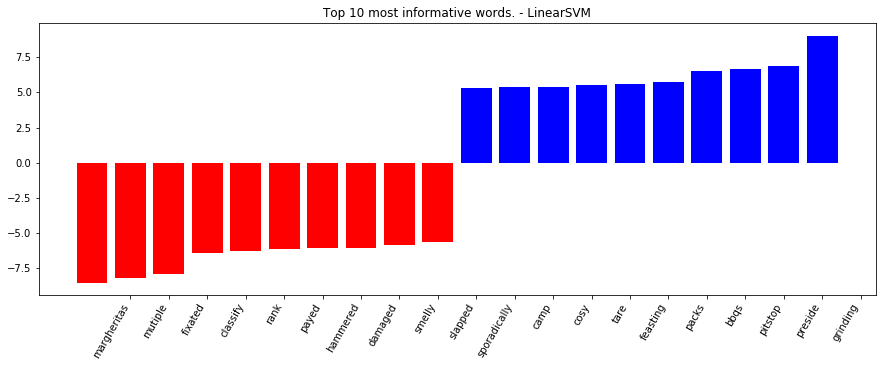

In [69]:
plot_coefficients(ppsvm, ppcv.get_feature_names())

# [7.6] Text Pre-Processing of Top 10 most informative words. - Navie Bayes

In [70]:
x_train_featspp = [(word_feats(c['text_preproc']), c['Sentiment']) for (d,c) in train_set.iterrows()]
classifier_nbpp = NaiveBayesClassifier.train(x_train_featspp)
print('---------------------------------------------------------------------------------------------')
print('|                     Top 10 most informative words. - Navie Bayes                          |')
print('---------------------------------------------------------------------------------------------')
classifier_nbpp.show_most_informative_features(10)
print('---------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------
|                     Top 10 most informative words. - Navie Bayes                          |
---------------------------------------------------------------------------------------------
Most Informative Features
              flavorless = True               -1 : 1      =     50.6 : 1.0
            unacceptable = True               -1 : 1      =     44.9 : 1.0
                  rudely = True               -1 : 1      =     39.1 : 1.0
               disgusted = True               -1 : 1      =     31.9 : 1.0
               poisoning = True               -1 : 1      =     31.7 : 1.0
              microwaved = True               -1 : 1      =     30.5 : 1.0
              disgusting = True               -1 : 1      =     29.5 : 1.0
                downhill = True               -1 : 1      =     26.6 : 1.0
                 apology = True               -1 : 1      =     26.3 : 1.0
                 

The most informative features shows the 'key' words that appear more in the negative reviews than the 
positive reviews. For eg., for the train set, the most informative classifier 'flavorless' 
which appears on average 4 time in bad reviews to good reviews. This is the conditional probability of it appearing in bad reviews. 'favorless' in this case makes sense.

# [7.7] Training SVM Model on K-BEST

Train and Test SVM with the k best selected features, K=5000 of the train set

In [71]:
kbest = SelectKBest(chi2, k=5000)
x_train_kbest = kbest.fit_transform(x_train_vec_pp, y_train_pp)
x_test_kbest = kbest.transform(x_test_vec_pp)

In [72]:
#Train your SVM with the k best selected features
svm_kbest_clf = train_svm(x_train_kbest, y_train) 

#Uncomment to export model out as pickles 
pk.dump(svm_kbest_clf, open("classifier_svm_kbest.pk","wb"))
#Uncomment to read from model.
#svm_kbest_clf = pk.load(open("classifier_svm_kbest.pk", "rb"))

In [73]:
svm_kbest_train_pred_1 = svm_kbest_clf.predict(x_train_kbest)
svm_kbest_train_1_cm   = pd.crosstab(pd.Series(y_train), pd.Series(svm_kbest_train_pred_1), rownames=['actual'], colnames=['predict'], margins=True)

print('-----------------------------------------------------')
print('| Summary Result of Train SVM KBest Model           |')
print('-----------------------------------------------------')
print(svm_kbest_train_1_cm)
print('-----------------------------------------------------')
print(metrics.classification_report(y_train, svm_kbest_train_pred_1))
print('-----------------------------------------------------')
print('Total Accuracy :' + str(round(np.mean(svm_kbest_train_pred_1 == y_train), 5)))
print('-----------------------------------------------------')

-----------------------------------------------------
| Summary Result of Train SVM KBest Model           |
-----------------------------------------------------
predict     -1      1    All
actual                      
-1       11200    739  11939
1          577  12280  12857
All      11777  13019  24796
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.95      0.94      0.94     11939
           1       0.94      0.96      0.95     12857

   micro avg       0.95      0.95      0.95     24796
   macro avg       0.95      0.95      0.95     24796
weighted avg       0.95      0.95      0.95     24796

-----------------------------------------------------
Total Accuracy :0.94693
-----------------------------------------------------


# [7.8] Test SVM Model on K-BEST

In [74]:
svm_kbest_test_pred_1 = svm_kbest_clf.predict(x_test_kbest)
svm_kbest_test_1_cm  = pd.crosstab(pd.Series(y_test), pd.Series(svm_kbest_test_pred_1), rownames=['actuals'], colnames=['predict'], margins=True)

print('-----------------------------------------------------')
print('| Summary Result of Test SVM KBest Model            |')
print('-----------------------------------------------------')
print(svm_kbest_test_1_cm)
print('-----------------------------------------------------')
print(metrics.classification_report(y_test, svm_kbest_test_pred_1))
print('-----------------------------------------------------')
print('Total Accuracy :' + str(round(np.mean(svm_kbest_test_pred_1 == y_test), 5)))
print('-----------------------------------------------------')

-----------------------------------------------------
| Summary Result of Test SVM KBest Model            |
-----------------------------------------------------
predict   -1    1  All
actuals               
-1        85   28  113
1         51  425  476
All      136  453  589
-----------------------------------------------------
              precision    recall  f1-score   support

          -1       0.62      0.75      0.68       113
           1       0.94      0.89      0.91       476

   micro avg       0.87      0.87      0.87       589
   macro avg       0.78      0.82      0.80       589
weighted avg       0.88      0.87      0.87       589

-----------------------------------------------------
Total Accuracy :0.86587
-----------------------------------------------------


# [7.9] Conclusion

In an attempt to improve the model results, we did text pre processing of the dataset before running the Navie Bayes and SVM model.  We also using k-best feautures on SVM to find the best classifier results.

To conlude, SVM with the pre-processed data provide the best possible result. This is because noise, stopword and lemmization prepared and better represent the sentiment of the data. 


### Why is linear kernel selected for SVM?
The linear kernel is good when there is a lot of features. That's because mapping the data to a higher dimensional space does not really improve the performance. [1]  In text classification, both the numbers of instances (document) and features (words) are large.

The decision boundary produced by a RBF kernel when the data is linearly separable is almost the same as the decision boundary produced by a linear kernel. Mapping data to a higher dimensional space using an RBF kernel was not useful.

# [8.0] Conclusion

[1] A Practical Guide to Support Vector Classification from https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

------------------------------------------------------------------------------------------------------------------